# Import Lib

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import albumentations as A
import os
import shutil
from tqdm import tqdm
from tensorflow.keras.callbacks import CSVLogger

/Users/phantakan/convolution/venv/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Import Dataset

In [ ]:
train_path = '/Users/phantakan/convolution/Dataset/Intel_Dataset/seg_train/seg_train'
pred_path = '/Users/phantakan/convolution/Dataset/Intel_Dataset/seg_pred/seg_pred'
test_path = '/Users/phantakan/convolution/Dataset/Intel_Dataset/seg_test/seg_test'
output_root = '/Users/phantakan/convolution/Dataset/Intel_Dataset/seg_train/seg_trian_augmented'

# Preprocessing Image before trianing model

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.2)

test_datagen = ImageDataGenerator(
    rescale=1./255, 
)

In [ ]:
bad_dirs = ['.ipynb_checkpoints']
for bad in bad_dirs:
    path = os.path.join(train_path, bad)
    if os.path.exists(path):
        shutil.rmtree(path)
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    output_root,
    target_size=(224,224),
    batch_size=64,
    class_mode = 'categorical',
    subset = "training",
    shuffle=True,
    seed = 42
    
)
print(train_generator.class_indices)

val_generator = train_datagen.flow_from_directory(
    output_root,
    target_size=(224,224),
    batch_size=64,
    class_mode = 'categorical',
    subset = "validation",
    seed = 42
)
print(val_generator.class_indices)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode = 'categorical',
    shuffle=False,
)


# ตรวจสอบขนาดของภาพจาก train_generator
for X_batch, y_batch in train_generator:
    print("Shape of first image in the batch:", X_batch.shape)
    break  # หยุดหลังจากดึงข้อมูลภาพแรกใน batch

# ตรวจสอบขนาดของภาพจาก val_generator
for X_batch, y_batch in val_generator:
    print("Shape of first image in the batch:", X_batch.shape)
    break  # หยุดหลังจากดึงข้อมูลภาพแรกใน batch

Found 22458 images belonging to 6 classes.
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Found 5610 images belonging to 6 classes.
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Found 3005 images belonging to 6 classes.
Shape of first image in the batch: (64, 224, 224, 3)
Shape of first image in the batch: (64, 224, 224, 3)


In [8]:
for folder in os.listdir(output_root):
    folder_path = os.path.join(output_root, folder)
    if os.path.isdir(folder_path):
        print(f"{folder}: {len(os.listdir(folder_path))} files")

forest: 4542 files
buildings: 4382 files
glacier: 4808 files
street: 4764 files
mountain: 5024 files
sea: 4548 files


# Convolution Block

In [ ]:
# def create_custom_model():
#     model = models.Sequential()

#     # Block 1
#     model.add(layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(150,150,3)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Conv2D(32, (3,3), padding="same", activation="relu"))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D((2,2)))

#     # Block 2
#     model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D((2,2)))

#     # Block 3
#     model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D((2,2)))

#     # Block 4 - Bottleneck (1x1)
#     model.add(layers.Conv2D(128, (1,1), padding="same", activation="relu"))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D((2,2)))

#     # Block 5
#     model.add(layers.Conv2D(256, (3,3), padding="same", activation="relu"))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D((2,2)))

#     # model.add(layers.Flatten())
#     model.add(layers.GlobalAveragePooling2D())

#     model.add(layers.Dense(128, activation="relu"))
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(6, activation="softmax"))

#     return model


In [ ]:
# def create_custom_model():
#   model = models.Sequential()

#   model.add(layers.Conv2D(32, (5,5), padding="same",input_shape=(150,150,3)))
#   model.add(layers.LeakyReLU(alpha=0.1))
#   model.add(layers.BatchNormalization())
#   model.add(layers.Conv2D(32,(3,3) ,padding="same"))
#   model.add(layers.LeakyReLU(alpha=0.1))
#   model.add(layers.BatchNormalization())
#   model.add(layers.MaxPooling2D((2,2)))
    
#   model.add(layers.Conv2D(64,(3,3) ,padding="same"))
#   model.add(layers.LeakyReLU(alpha=0.1))
#   model.add(layers.BatchNormalization())
#   model.add(layers.Conv2D(64,(3,3) ,padding="same"))
#   model.add(layers.LeakyReLU(alpha=0.1))
#   model.add(layers.BatchNormalization())
#   model.add(layers.MaxPooling2D((2,2)))

#   model.add(layers.Conv2D(64,(1,1) ,padding="same"))
#   model.add(layers.LeakyReLU(alpha=0.1))
#   model.add(layers.BatchNormalization())
#   model.add(layers.Conv2D(128,(3,3), padding="same"))
#   model.add(layers.LeakyReLU(alpha=0.1))
#   model.add(layers.BatchNormalization())
#   model.add(layers.MaxPooling2D((2,2)))
    
#   model.add(layers.Conv2D(128,(1,1),padding="same"))
#   model.add(layers.LeakyReLU(alpha=0.1))
#   model.add(layers.BatchNormalization())
#   model.add(layers.Conv2D(128,(3,3),padding="same"))
#   model.add(layers.LeakyReLU(alpha=0.1))
#   model.add(layers.BatchNormalization())
#   model.add(layers.MaxPooling2D((2,2)))

#   model.add(layers.Conv2D(256,(3,3),padding="same"))
#   model.add(layers.LeakyReLU(alpha=0.1))
#   model.add(layers.BatchNormalization())
#   model.add(layers.Conv2D(512,(3,3),padding="same"))
#   model.add(layers.LeakyReLU(alpha=0.1))
#   model.add(layers.BatchNormalization())
#   model.add(layers.MaxPooling2D((2, 2)))

#   model.add(layers.Dropout(0.2))
#   # model.add(layers.Flatten())
#   model.add(layers.GlobalAveragePooling2D())
#   model.add(layers.Dense(128))
#   model.add(layers.LeakyReLU(alpha=0.1))
#   model.add(layers.Dropout(0.5))
    
#   model.add(layers.Dense(6,activation = "softmax"))

#   return model

In [ ]:
# def create_custom_model():
#   model = models.Sequential()

#   model.add(layers.Conv2D(32, (3,3), padding="same",input_shape=(150,150,3)))
#   model.add(layers.ELU(alpha=0.1))
#   model.add(layers.Conv2D(32, (3,3), padding="same"))
#   model.add(layers.ELU(alpha=0.1))
#   model.add(layers.MaxPooling2D((2,2)))
    
#   model.add(layers.Conv2D(64,(3,3) ,padding="same"))
#   model.add(layers.ELU(alpha=0.1))
#   model.add(layers.MaxPooling2D((2,2)))

#   model.add(layers.Conv2D(128,(3,3), padding="same"))
#   model.add(layers.ELU(alpha=0.1))
#   model.add(layers.MaxPooling2D((2,2)))
    
#   model.add(layers.Conv2D(128,(1,1),padding="same"))
#   model.add(layers.ELU(alpha=0.1))
#   model.add(layers.MaxPooling2D((2,2)))

#   model.add(layers.Conv2D(256,(3,3),padding="same"))
#   model.add(layers.ELU(alpha=0.1))
#   model.add(layers.MaxPooling2D((2, 2)))
    
#   # model.add(layers.Flatten())
#   model.add(layers.GlobalAveragePooling2D())
#   model.add(layers.Dense(128))
#   model.add(layers.ELU(alpha=0.1))
#   model.add(layers.Dropout(0.5))
    
#   model.add(layers.Dense(6,activation = "softmax"))

#   return model

# Model Summary

In [10]:
model = create_custom_model()

model.summary()

/Users/phantakan/convolution/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-29 10:17:06.687086: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-05-29 10:17:06.687135: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-29 10:17:06.687141: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1748488626.687158 2802303 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1748488626.687192 2802303 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 18, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,119,334 (4.27 MB)

 Trainable params: 1,119,334 (4.27 MB)

 Non-trainable params: 0 (0.00 B)

# Compile Model

In [11]:
model.compile(optimizer=Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# Training Model

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=4,            
    restore_best_weights=True  
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
csv_logger = CSVLogger('training_log.csv', append=True)
history = model.fit(train_generator,
                    epochs=5,
                    validation_data = val_generator,
                    callbacks=[early_stopping,reduce_lr,csv_logger]
                   )

# Plot accuracy

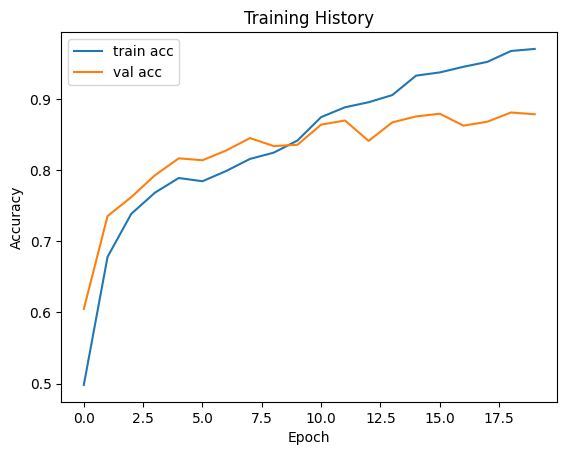

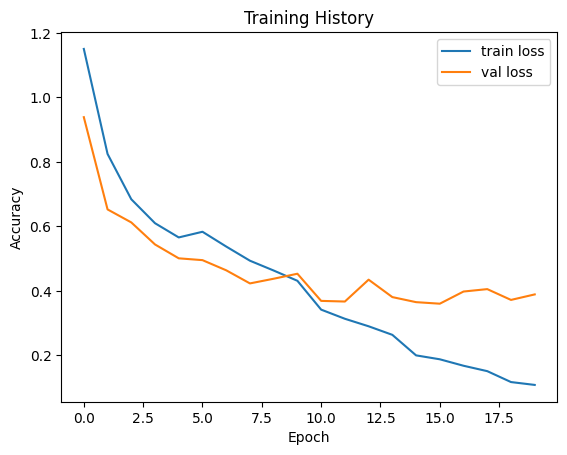

In [69]:
plt.plot(history.history['accuracy'], label ='train acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History')
plt.show()

plt.plot(history.history['loss'], label ='train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History')
plt.show()

# Evaluate the Model (Validation)

In [86]:
test_loss, test_acc = model.evaluate(val_generator)
print(f"Test Accuracy: {test_acc:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.8805 - loss: 0.3537
Test Accuracy: 0.8797


# Save weight h5

In [12]:
model.save_weights("model-leakyrely-transformv5.weights.h5")

# Evaluate the Model (Test)

In [91]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.8934 - loss: 0.3748
Test loss: 0.4259
Test accuracy: 0.8702
